In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
infiles = {
    'ACCESS-CM2': 'example_data/spei_mon_ACCESS-CM2_ssp370_ensemble_aus-states_1850-2100.csv',
    'MPI-ESM1-2-LR' : 'example_data/spei_mon_MPI-ESM1-2-LR_ssp370_ensemble_aus-states_1850-2100.csv',
}

In [11]:
df_dict = {}
df = pd.read_csv(infiles['ACCESS-CM2'])
df_dict['ACCESS-CM2'] = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()

df = pd.read_csv(infiles['MPI-ESM1-2-LR'])
df_dict['MPI-ESM1-2-LR'] = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()

In [12]:
df_dict['ACCESS-CM2']

,year,run,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
0,1850,r10i1p1f1,-0.980000,-0.250000,-0.410000,0.420000,0.980000,-0.830000,-0.150000,0.140000
1,1850,r1i1p1f1,-0.910000,-0.170000,-1.240000,-0.150000,-0.420000,0.280000,-0.260000,-0.580000
2,1850,r2i1p1f1,-0.920000,-0.170000,-0.750000,-0.880000,-1.170000,0.200000,-0.790000,-0.900000
3,1850,r3i1p1f1,-0.760000,-0.390000,-1.250000,-0.020000,0.660000,-0.220000,-0.800000,-0.300000
4,1850,r4i1p1f1,-0.700000,-0.480000,-0.060000,-0.530000,-0.450000,-0.460000,-0.380000,-0.390000
...,...,...,...,...,...,...,...,...,...,...
2505,2100,r5i1p1f1,-2.308333,-2.741667,-3.015000,-4.863333,-3.941667,-2.088333,-3.576667,-3.565833
2506,2100,r6i1p1f1,0.483333,-0.690833,-0.556667,-1.196667,-1.647500,-0.676667,-1.370000,-1.037500
2507,2100,r7i1p1f1,-0.825000,-2.004167,-2.439167,-2.998333,-1.606667,-2.459167,-1.925000,-1.965833
2508,2100,r8i1p1f1,-0.662500,-2.244167,-0.170833,-2.376667,-2.638333,-0.564167,-0.454167,-1.430833


In [5]:
def plot_location(model, location, start_year=1950):
    """Scatterplot for a given location"""

    df = df_dict[model]
    fig, ax = plt.subplots(figsize=[15,7])
    sns.scatterplot(
        ax=ax,
        data=df[df['year'] >= start_year],
        x='year',
        y=location,
        hue='run',
    )
    ax.set_ylabel('SPEI')
    ax.set_title(f'{model} - {location}')
    ax.grid()
    plt.show()

In [6]:
def plot_dist(model, location, start_year=1950, end_year=2014):
    """Histogram for a given location"""

    df = df_dict[model]
    df_ref = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    fig, ax = plt.subplots()
    sns.histplot(
        ax=ax,
        data=df_ref,
        x=location,
    )
    ax.set_ylabel('SPEI')
    ax.set_title(f'{model} - {location}')
    ax.grid()
    plt.show()

In [16]:
def plot_odds(model, location, window, step, ref_start=1950, ref_end=2014):
    """Histogram for a given location"""

    df = df_dict[model]
    df_ref = df[(df['year'] >= ref_start) & (df['year'] <= ref_end)]
    p02 = df_ref[location].quantile(0.02)

    odds = df[location].rolling(window, step=step).apply(lambda s: (sum(s < p02) / window) * 100)
    odds.index = df['year'].unique()

    fig, ax = plt.subplots()
    sns.lineplot(
        ax=ax,
        data=odds,
    )
    ax.set_xlabel('year')
    ax.set_ylabel('odds of exceeding 1-in-50 year event (%)') 
    ax.set_title(f'SPEI - {model} - {location}')
    ax.grid()
    plt.show()

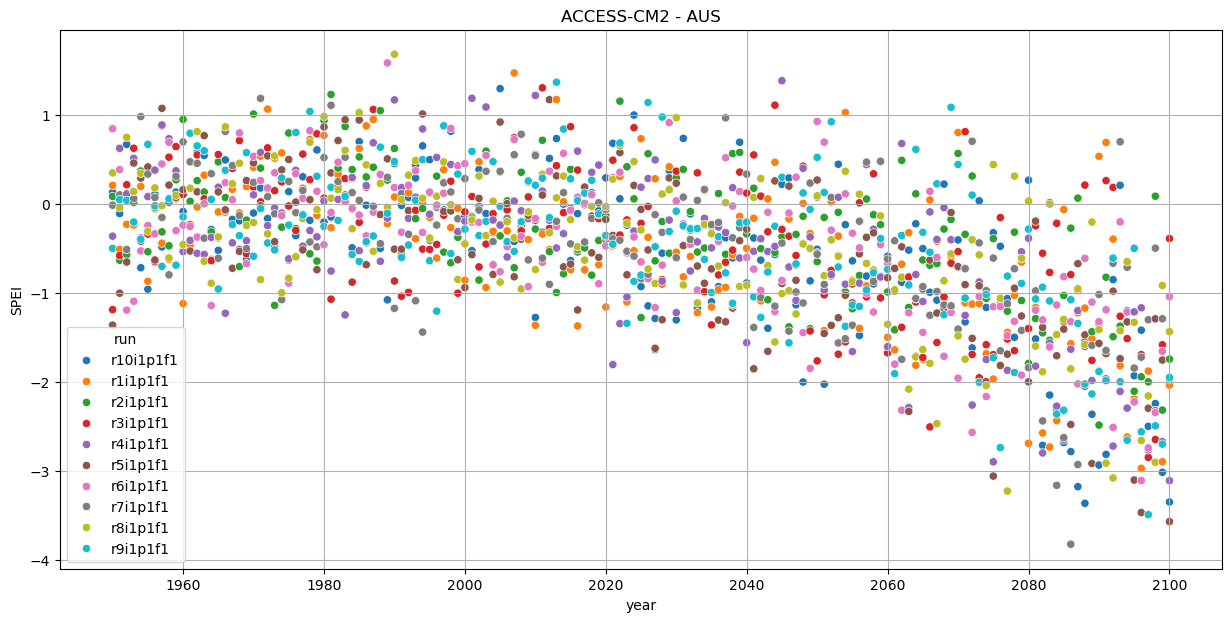

In [13]:
plot_location('ACCESS-CM2', 'AUS')

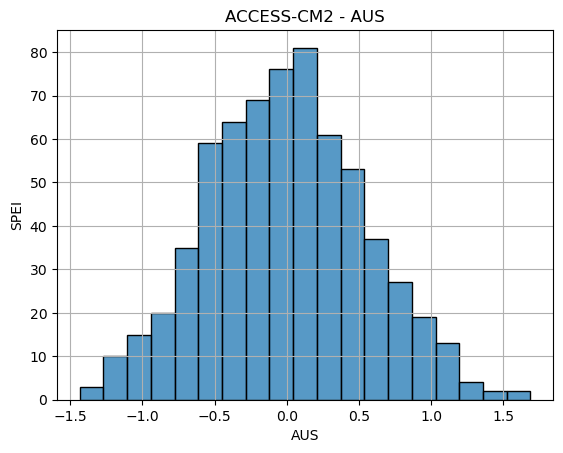

In [14]:
plot_dist('ACCESS-CM2', 'AUS')

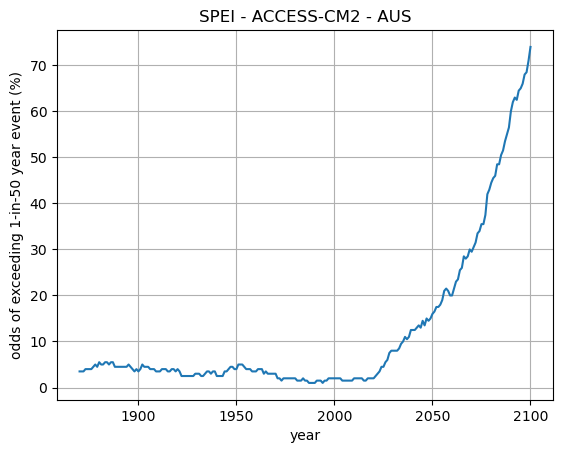

In [17]:
plot_odds('ACCESS-CM2', 'AUS', window=200, step=10)

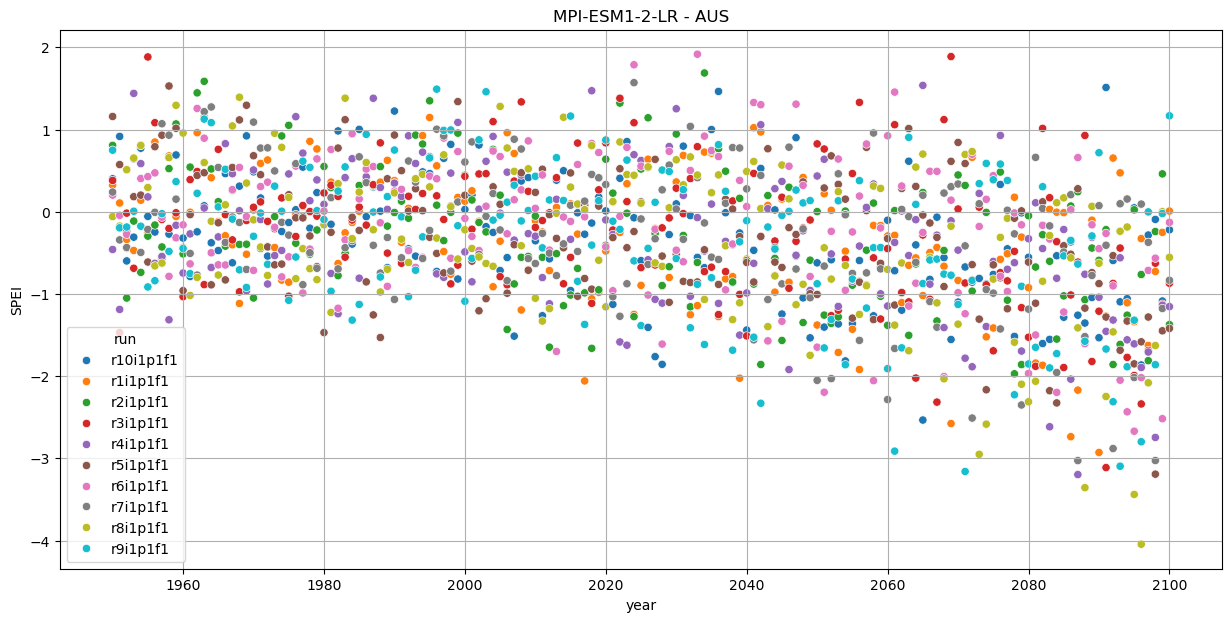

In [18]:
plot_location('MPI-ESM1-2-LR', 'AUS')

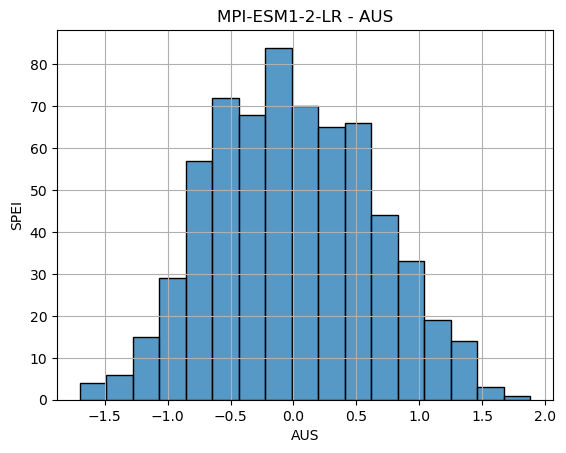

In [19]:
plot_dist('MPI-ESM1-2-LR', 'AUS')

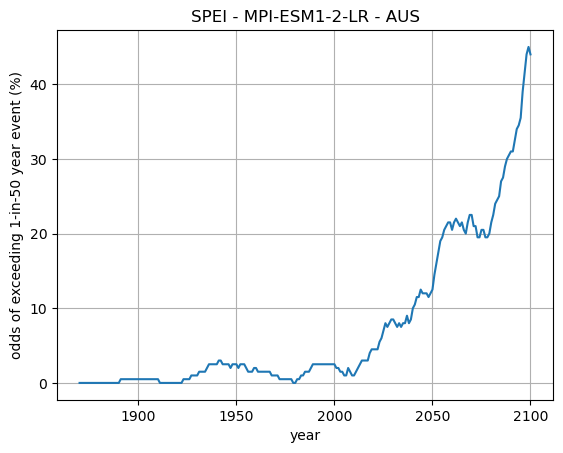

In [20]:
plot_odds('MPI-ESM1-2-LR', 'AUS', window=200, step=10)